In [27]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as smapi
import statsmodels.tsa as smtsa
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [28]:
sun_spots = smapi.datasets.sunspots.load_pandas().data
sun_spots.index = pd.to_datetime(sun_spots.YEAR, format='%Y')
y = sun_spots.drop('YEAR', axis=1)
y = y.squeeze()

In [29]:
y

YEAR
1700-01-01     5.0
1701-01-01    11.0
1702-01-01    16.0
1703-01-01    23.0
1704-01-01    36.0
              ... 
2004-01-01    40.4
2005-01-01    29.8
2006-01-01    15.2
2007-01-01     7.5
2008-01-01     2.9
Name: SUNACTIVITY, Length: 309, dtype: float64

In [30]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 309 entries, 1700-01-01 to 2008-01-01
Series name: SUNACTIVITY
Non-Null Count  Dtype  
--------------  -----  
309 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [31]:
result = smtsa.stattools.adfuller(y.values, autolag='AIC')
print(f'ADF-статистика: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Критичні значення:')
    print(f'{key}, {value}')

ADF-статистика: -2.8377807249381966
p-value: 0.05307642172812041
Критичні значення:
1%, -3.4523371197407404
Критичні значення:
5%, -2.871222860740741
Критичні значення:
10%, -2.571929211111111


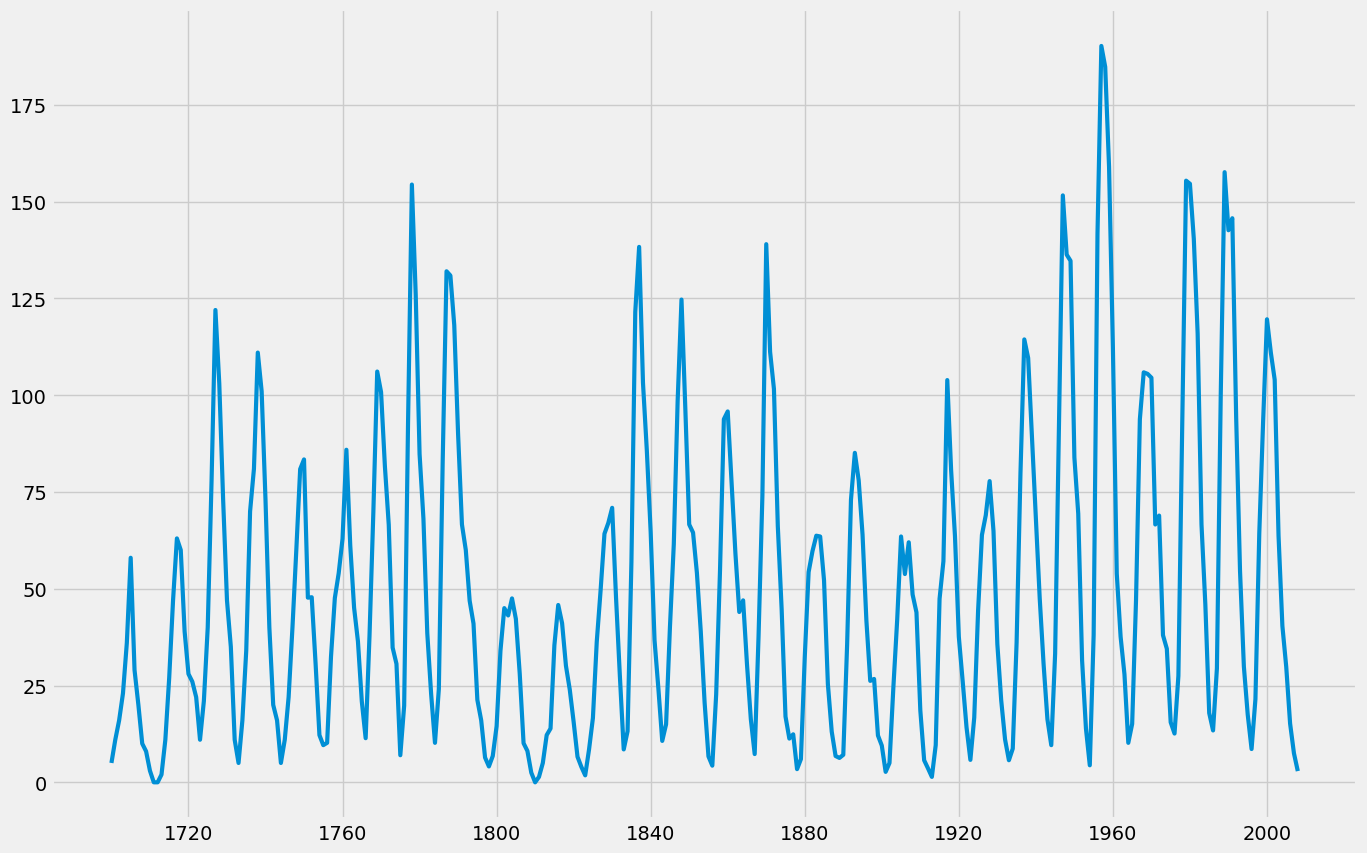

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(y, linewidth=3)

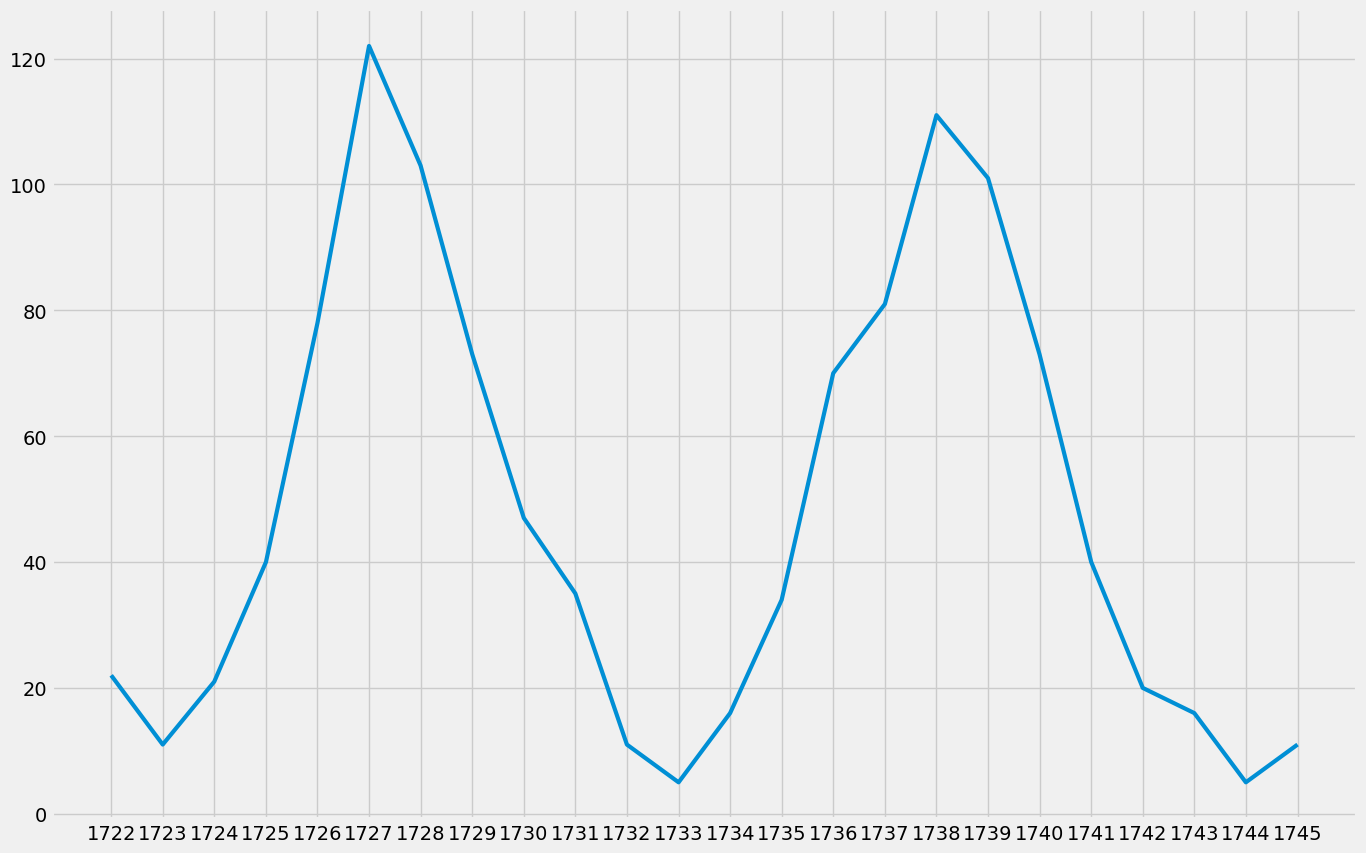

In [33]:
plt.figure(figsize=(15, 10))
plt.xticks(y['1722-01-01':'1745-01-01'].index, labels=np.arange(1722, 1746))
plt.plot(y['1722-01-01':'1745-01-01'], linewidth=3)

In [34]:
p = d = q = range(0, 2)
# Генеруємо різні комбінації p, q и q
pdq = list(itertools.product(p, d, q))
# Генеруємо комбінації різних сезонних параметрів p, d, q
seasonal_pdq = [(x[0], x[1], x[2], 11) for x in list(itertools.product(p, d, q))] 

In [35]:
warnings.filterwarnings("ignore") # Вимикаємо попередження
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.arima.model.ARIMA(y,
        order=param,
        seasonal_order=param_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}11 - AIC:{}'.format(param, param_seasonal, results.aic))
        aic.append(results.aic)
print('Min AIC:', min(aic))

ARIMA(0, 0, 0)x(0, 0, 0, 11)11 - AIC:3156.11641151436
ARIMA(0, 0, 0)x(0, 0, 1, 11)11 - AIC:2926.917959024923
ARIMA(0, 0, 0)x(0, 1, 0, 11)11 - AIC:2919.0838255745502
ARIMA(0, 0, 0)x(0, 1, 1, 11)11 - AIC:2803.5606141728786
ARIMA(0, 0, 0)x(1, 0, 0, 11)11 - AIC:2880.0304749155257
ARIMA(0, 0, 0)x(1, 0, 1, 11)11 - AIC:2872.824762418548
ARIMA(0, 0, 0)x(1, 1, 0, 11)11 - AIC:2817.8910308658983
ARIMA(0, 0, 0)x(1, 1, 1, 11)11 - AIC:2786.8643331563953
ARIMA(0, 0, 1)x(0, 0, 0, 11)11 - AIC:2868.2616353280073
ARIMA(0, 0, 1)x(0, 0, 1, 11)11 - AIC:2692.001652908709
ARIMA(0, 0, 1)x(0, 1, 0, 11)11 - AIC:2715.516529390423
ARIMA(0, 0, 1)x(0, 1, 1, 11)11 - AIC:2588.2913659466053
ARIMA(0, 0, 1)x(1, 0, 0, 11)11 - AIC:2671.2758063518804
ARIMA(0, 0, 1)x(1, 0, 1, 11)11 - AIC:2654.4347774964103
ARIMA(0, 0, 1)x(1, 1, 0, 11)11 - AIC:2618.286419811578
ARIMA(0, 0, 1)x(1, 1, 1, 11)11 - AIC:2573.2650259756447
ARIMA(0, 1, 0)x(0, 0, 0, 11)11 - AIC:2824.8598075257105
ARIMA(0, 1, 0)x(0, 0, 1, 11)11 - AIC:2667.934440574947


In [36]:
model = sm.tsa.arima.model.ARIMA(y,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 11),
        enforce_stationarity=False,
        enforce_invertibility=False)
result = model.fit()

In [37]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3023,0.088,3.417,0.001,0.129,0.476
ma.L1,0.1819,0.092,1.980,0.048,0.002,0.362
ar.S.L11,0.0145,0.028,0.524,0.600,-0.040,0.069
ma.S.L11,-0.8807,0.048,-18.283,0.000,-0.975,-0.786
sigma2,364.4575,24.049,15.155,0.000,317.323,411.592


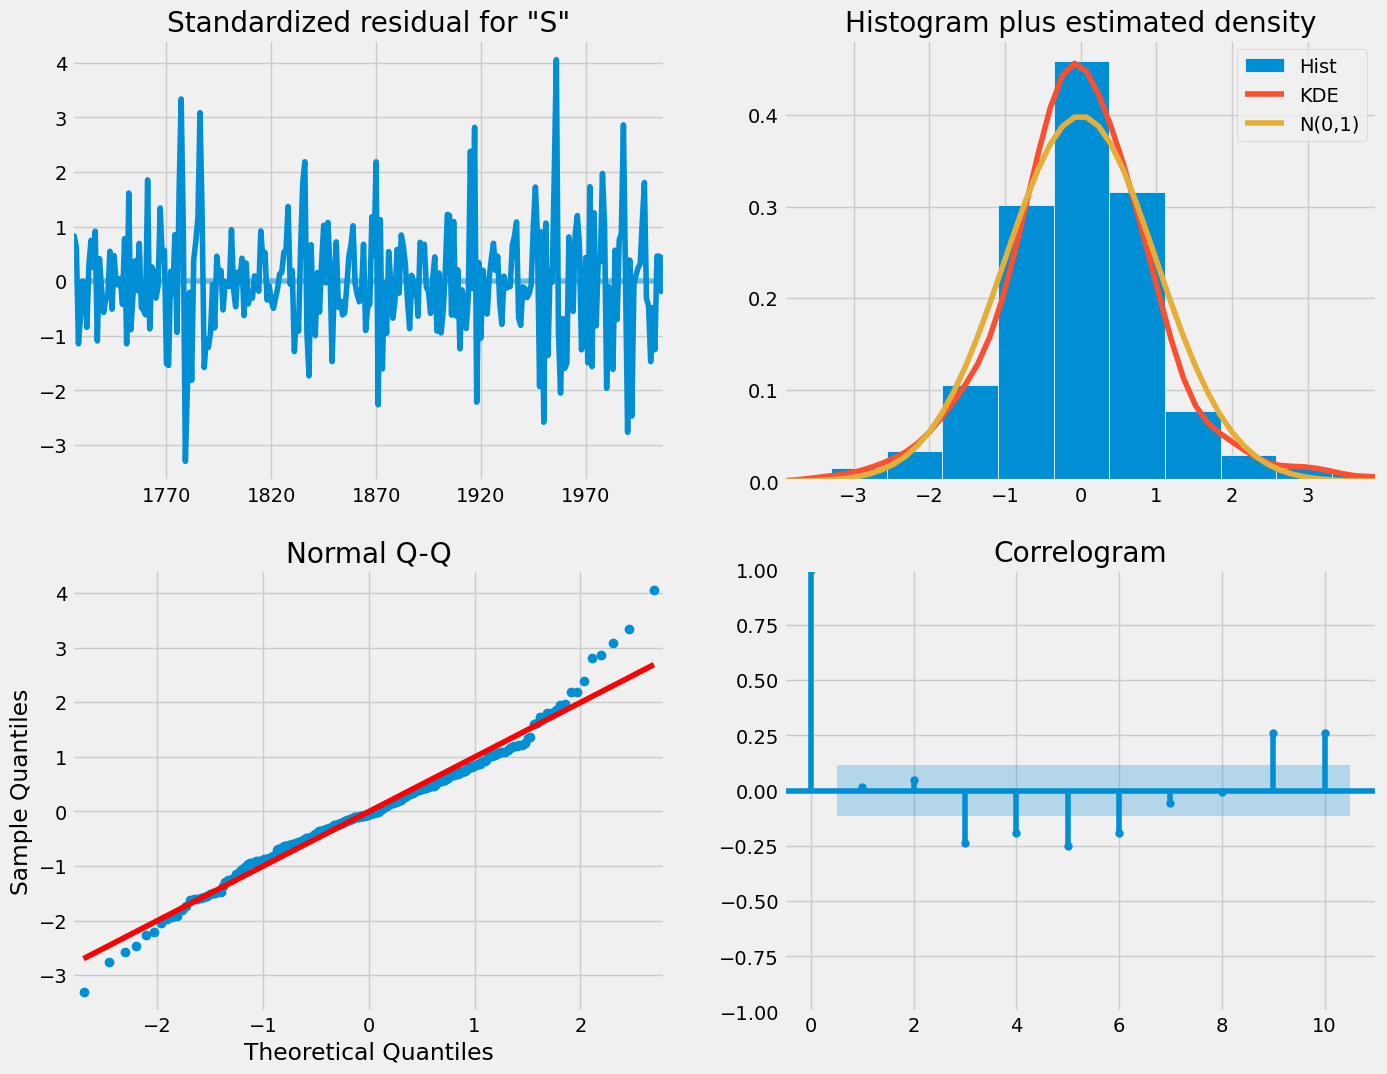

In [38]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [39]:
pred = results.get_prediction(start=pd.to_datetime('1950-01-01'), dynamic=False)
pred_ci = pred.conf_int()

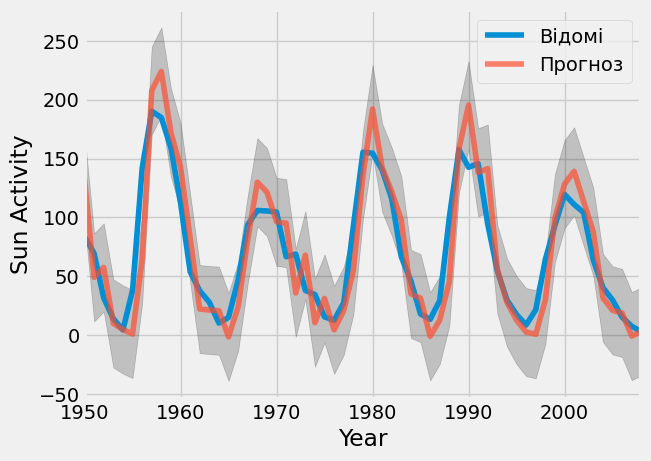

In [40]:
ax = y['1950-01-01':].plot()
pred.predicted_mean.plot(ax=ax, alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Sun Activity')
plt.legend(labels=['Відомі', 'Прогноз'])
plt.show()

In [41]:
y_forecasted = pred.predicted_mean
y_truth = y['1950-01-01':] # Обчислюємо середню квадртичну похибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Середня квадратна похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратна похибка прогнозів = 630.84


In [42]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

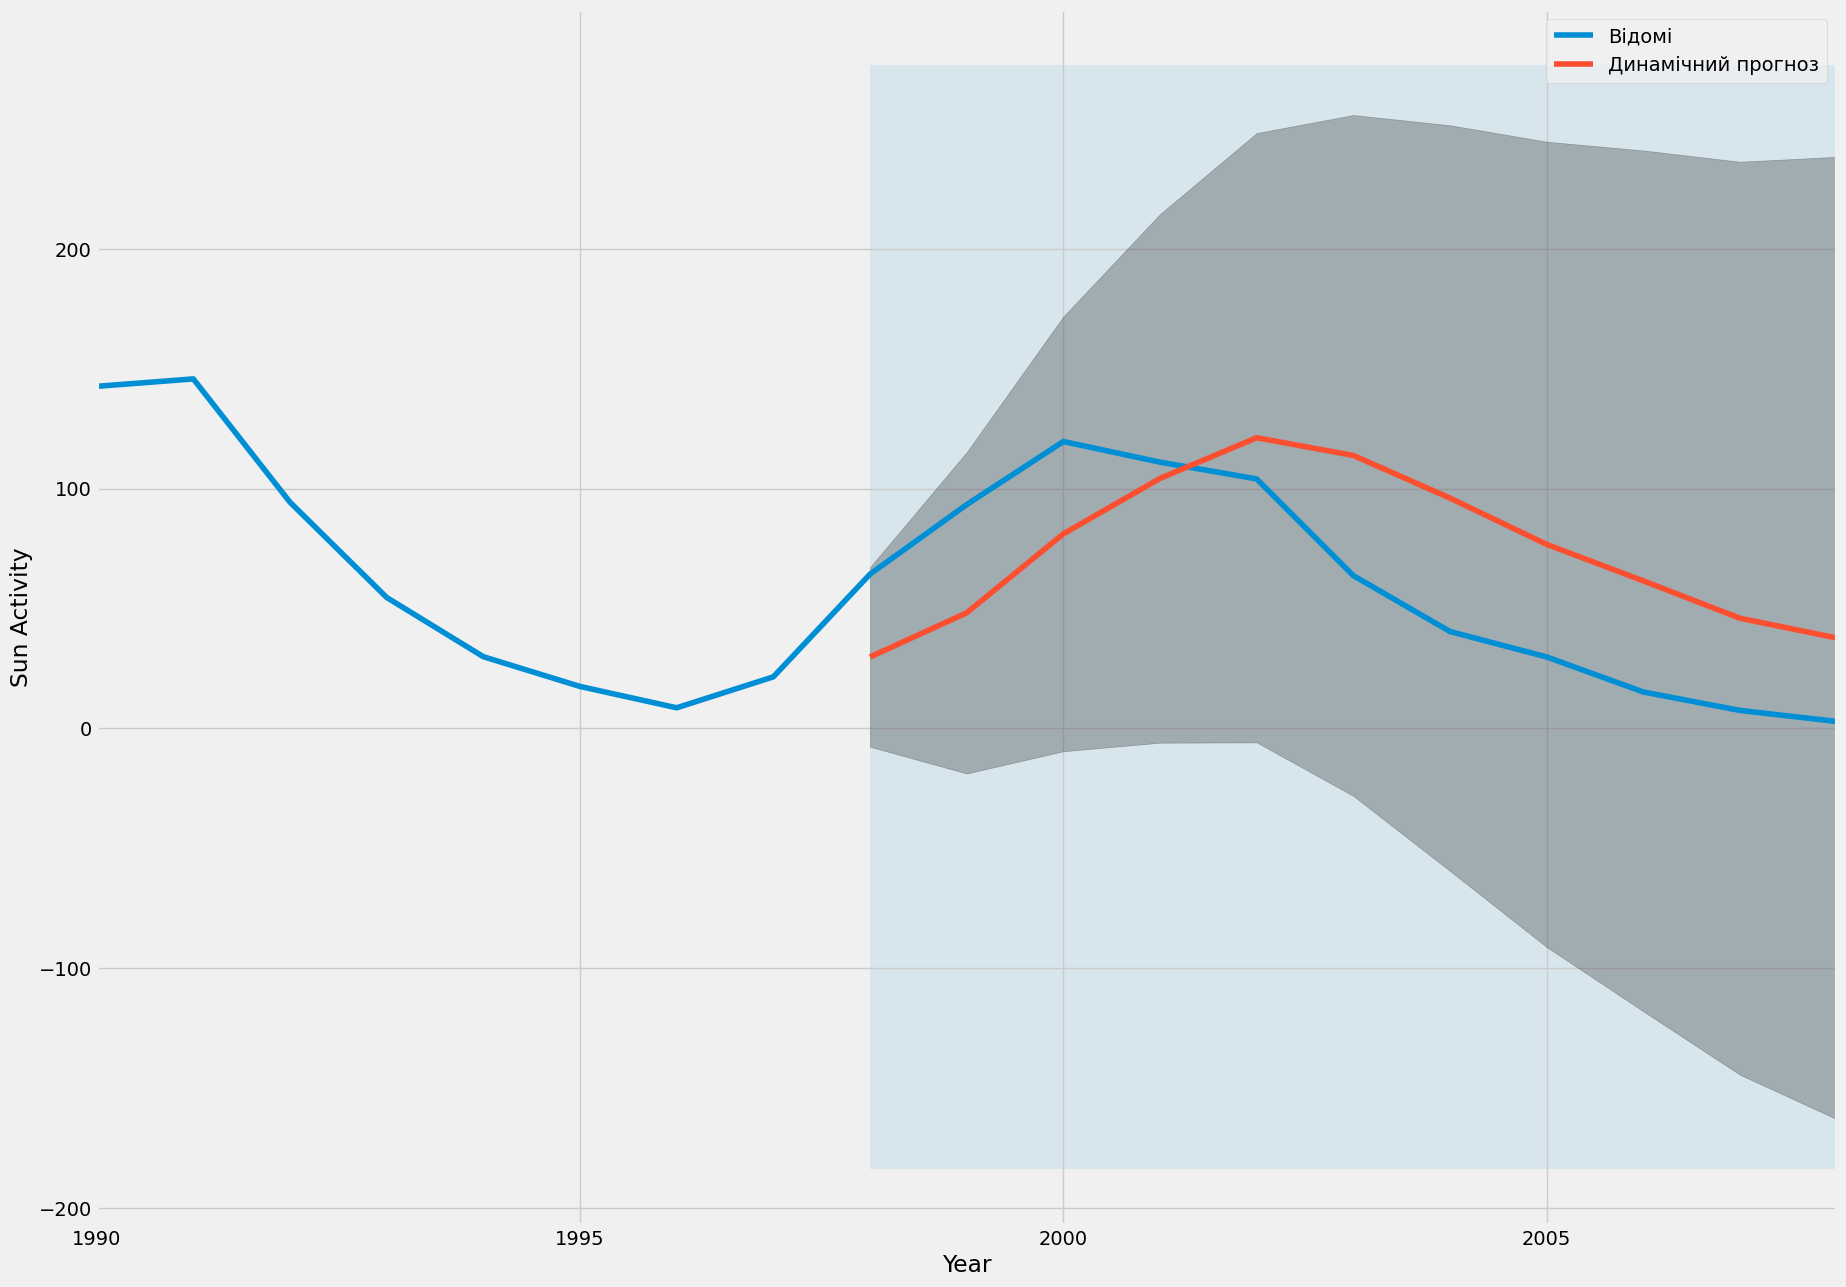

In [43]:
ax = y['1990':].plot(label='Відомі', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Динамічний прогноз', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Year')
ax.set_ylabel('Sun Activity')
plt.legend()
plt.show()

In [44]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':] # Отримуємо середню квадратичну похибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Середня квадратна похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратна похибка прогнозів = 1608.07


In [45]:
# Отримуємо прогноз на 50 кроків у перед
pred_uc = results.get_forecast(steps=50)
# Отримуємо інтервал прогнозу
pred_ci = pred_uc.conf_int()

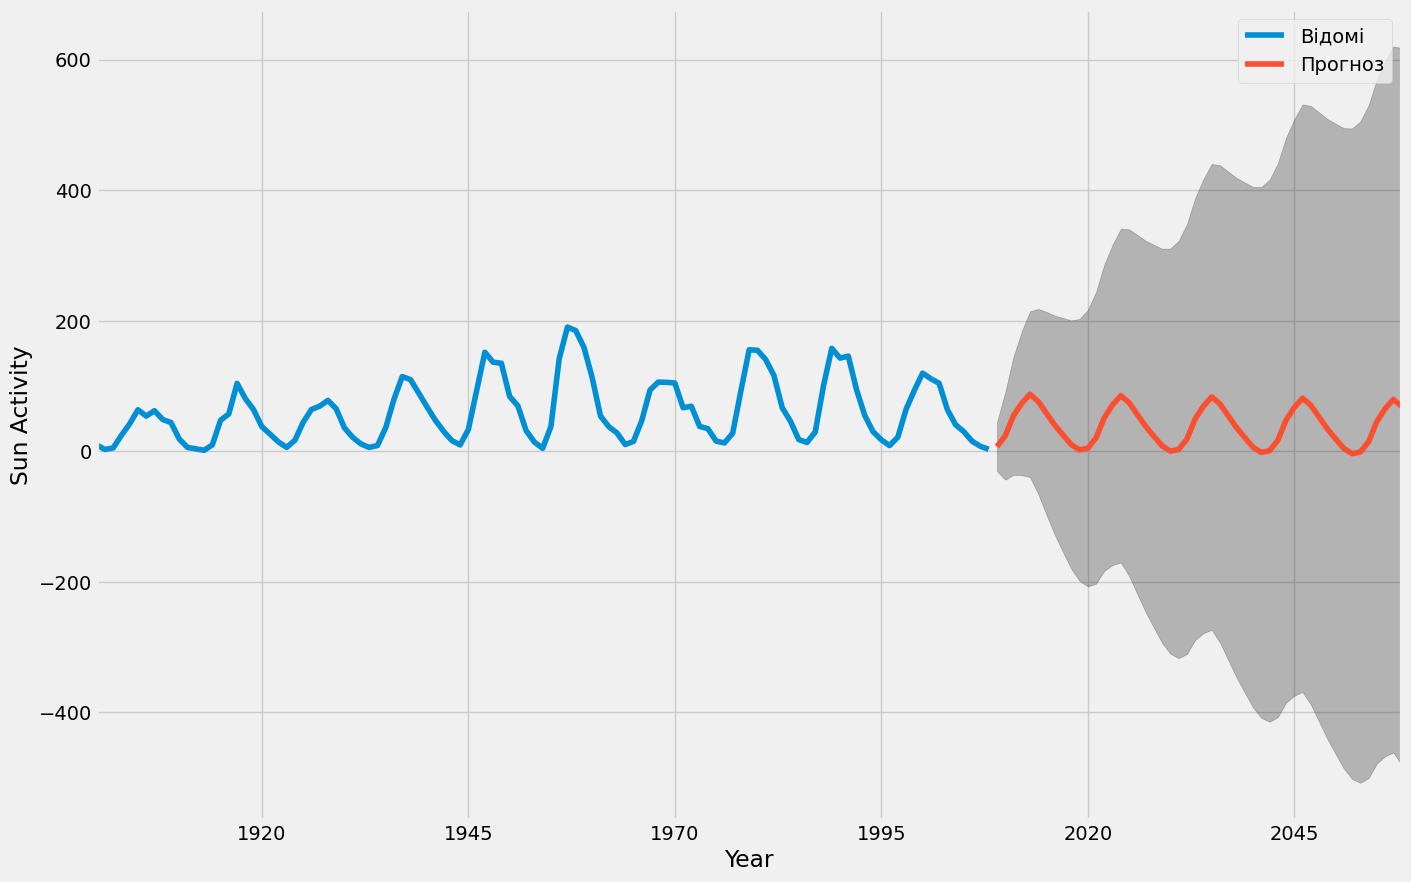

In [46]:
ax = y['1900':].plot(label='Відомі', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sun Activity')
plt.legend()
plt.show()